In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 假設有3個類別
num_classes = 3
batch_size = 4

# 模擬模型輸出 (未經softmax)
# 輸出形狀應為 [batch_size, num_classes]
predictions = torch.randn(batch_size, num_classes)

# 模擬真實標籤，假設為one-hot編碼
# 形狀為 [batch_size, num_classes]
targets_one_hot = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 1, 0]
], dtype=torch.float32)

# 將one-hot編碼的標籤轉換為類別索引
# 形狀為 [batch_size]
targets = torch.argmax(targets_one_hot, dim=1)

# 定義損失函數
criterion = nn.CrossEntropyLoss()

# 計算損失
loss = criterion(predictions, targets)
print(loss)


tensor(0.8943)


In [2]:
predictions

tensor([[-0.2698,  0.7174, -0.2358],
        [ 1.4976, -1.1554,  3.3826],
        [-0.8067,  1.1254,  1.9788],
        [ 1.3467,  0.7573, -1.5764]])

In [3]:
targets

tensor([0, 1, 2, 1])

In [6]:
print(x for x in range(1, 76))

<generator object <genexpr> at 0x7fd0786385f0>


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
import timm


class ModifiedXception(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedXception, self).__init__()
        
        # 加載 Xception 預訓練模型，去掉最後一層 (fc 層)
        self.base_model = timm.create_model(
            'xception', 
            pretrained=True, 
            features_only=True, # 只保留特徵提取部分
            out_indices=[3] # 選擇特徵層索引（根據模型結構）
            )
        
        # 自定義分類頭
        self.custom_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling,
            nn.Flatten(),
            nn.Linear(728, 368),    # Xception 輸出特徵維度為2048
            nn.ReLU(),               # 可選激活函數
            nn.Linear(368, num_classes),
            nn.Sigmoid()
        )

        # self.base_model.fc = nn.Identity()  # 移除原來的 fully connected 層
        
        # # 新增全局平均池化層、隱藏層和輸出層
        # self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # 全局平均池化
        # self.hidden_layer = nn.Linear(2048, 1370)  # 隱藏層，輸入大小取決於 Xception 的輸出大小
        # self.output_layer = nn.Linear(1370, 2)  # 輸出層，依據分類數目設定
        
        # # 激活函數與 dropout
        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.base_model(x)               # Xception 主體
        return x


In [13]:
def construct_model():
    '''決定我這次訓練要用哪個model'''
    cnn_model = ModifiedXception(3)

    if torch.cuda.device_count() > 1:
        cnn_model = nn.DataParallel(cnn_model)

    cnn_model = cnn_model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    return cnn_model

model = construct_model()
a = model.base_model.feature_info

for b in a:
    print(b)

# last = a[-1]
# last_conv_name = last['module']  # 這通常是 PyTorch Module 的名稱

# last_layer = dict(model.base_model.named_modules()).get(last_conv_name)
# print(f"最後的卷積層: {last_layer}")

# print(last_conv_name)

/opt/conda/lib/python3.11/site-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


{'num_chs': 64, 'reduction': 2, 'module': 'act2', 'index': 0}
{'num_chs': 128, 'reduction': 4, 'module': 'block2.rep.0', 'index': 1}
{'num_chs': 256, 'reduction': 8, 'module': 'block3.rep.0', 'index': 2}
{'num_chs': 728, 'reduction': 16, 'module': 'block12.rep.0', 'index': 3}
{'num_chs': 2048, 'reduction': 32, 'module': 'act4', 'index': 4}


In [ ]:
for c in model.named_modules():
    print(c)

 ModifiedXception(
  (base_model): FeatureHookNet(
    (body): Xception(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
      (block1): Block(
        (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rep): Sequential(
          (0): SeparableConv2d(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (1): BatchNorm2d(128, eps=1e-05, momentum=

In [23]:
model.base_model.body.conv4.pointwise

Conv2d(1536, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [ ]:
from sklearn.model_selection import KFold

k = KFold(n_splits = 5, shuffle = True)
a = [1, 2, 3, 4 ,5, 6,7, 8]

for d, (b, c) in enumerate(k.split(a)):
    print(d, b, c)

[(array([0, 2, 3, 4, 5, 6]), array([1, 7])), (array([0, 1, 2, 4, 5, 7]), array([3, 6])), (array([0, 1, 3, 4, 6, 7]), array([2, 5])), (array([0, 1, 2, 3, 5, 6, 7]), array([4])), (array([1, 2, 3, 4, 5, 6, 7]), array([0]))]
0 [0 2 3 4 5 6] [1 7]
1 [0 1 3 4 6 7] [2 5]
2 [1 2 4 5 6 7] [0 3]
3 [0 1 2 3 5 6 7] [4]
4 [0 1 2 3 4 5 7] [6]


In [ ]:
from torch.utils.data import Subset, DataLoader, Dataset

class ListDataset(Dataset):
    def __init__(self, data_list, labels_list, status):
        self.data = data_list
        self.labels = labels_list
        self.status = status

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]  

        if self.status:
            from Image_Process.Image_Generator import Image_generator
            ImageGenerator = Image_generator("", "", 12)
            Transform = ImageGenerator.Generator_Content(5)
            sample = Transform(sample)

        label = self.labels[idx]
        return sample, label

k = KFold(n_splits = 5, shuffle = True)
a = [1, 2, 3, 4 ,5, 6,7, 8]
label = [10, 20, 30, 40, 50,60, 70, 80]

f = ListDataset(a, label, True)

for d, (b, c) in enumerate(k.split(a)):
    # Create training and validation subsets for this fold
    train_subset = torch.utils.data.Subset(training_dataset, train_idx)
    val_subset = torch.utils.data.Subset(training_dataset, val_idx)



Gaussian Kernel:
 [[0.00134197 0.00407653 0.00794    0.00991586 0.00794    0.00407653
  0.00134197]
 [0.00407653 0.01238341 0.02411958 0.03012171 0.02411958 0.01238341
  0.00407653]
 [0.00794    0.02411958 0.04697853 0.05866909 0.04697853 0.02411958
  0.00794   ]
 [0.00991586 0.03012171 0.05866909 0.07326883 0.05866909 0.03012171
  0.00991586]
 [0.00794    0.02411958 0.04697853 0.05866909 0.04697853 0.02411958
  0.00794   ]
 [0.00407653 0.01238341 0.02411958 0.03012171 0.02411958 0.01238341
  0.00407653]
 [0.00134197 0.00407653 0.00794    0.00991586 0.00794    0.00407653
  0.00134197]]
Sum of kernel: 1.0


In [9]:
a = [[0, 1, 2, 3], [4, 5, 6, 7]]
b = [[0, 0, 1], [0, 0, 1]]

c = zip(a, b)
print(list(c))

print(list(zip(zip(*c))))

[([0, 1, 2, 3], [0, 0, 1]), ([4, 5, 6, 7], [0, 0, 1])]
[]


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score

a = np.array([0 ,1, 1, 0, 0])
b = np.array([1, 0, 1, 1, 0])

print((a == b).mean())
print(accuracy_score(a, b))

0.4
0.4


In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from Training_Tools.PreProcess import Training_Precesses

# Define a transform (e.g., resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example size
    transforms.ToTensor()
])

image_folder = ImageFolder("../Dataset/Training", transform = transform)
Data = DataLoader(dataset = image_folder, batch_size = 64, shuffle=True, num_workers = 0, pin_memory=True)

for images, labels in Data:
    print(images)
    break

Train = Training_Precesses(224)
Dataset = Train.Setting_DataSet("../Dataset/Training/stomach_cancer_Crop/", [1, 0, 0], "Training")
Data = DataLoader(dataset = Dataset, batch_size = 64, shuffle=True, num_workers = 0, pin_memory=True)
for images, labels in Data:
    print(images)
    break

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

[ WARN:0@13914.976] global loadsave.cpp:268 findDecoder imread_('a'): can't open/read file: check file path/integrity


ValueError: pic should be 2/3 dimensional. Got 0 dimensions.

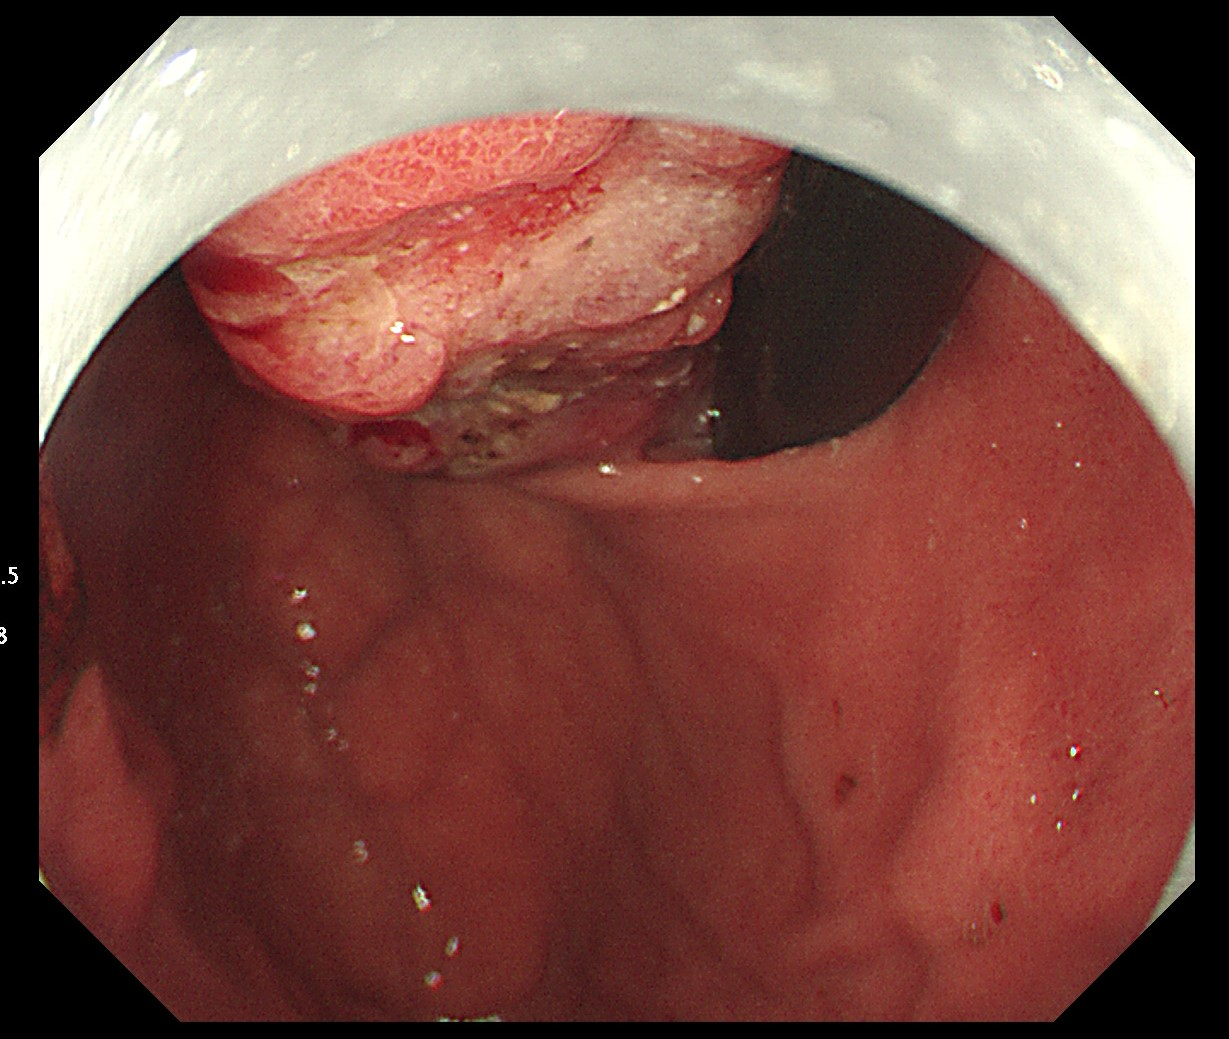

In [10]:
from PIL import Image
import numpy as np
import cv2

# image = cv2.imread('../Dataset/Training/stomach_cancer_Crop/C15_2.jpg', cv2.IMREAD_COLOR) # 讀檔(彩色)

image = Image.open('../Dataset/Training/stomach_cancer_Crop/A01.jpg').convert("RGB")

Image._show(image)
# # image = image.resize( (256, 256) ) #指定長與寬並進行縮圖製作
# image = np.array(image)
# # image = image.reshape(-1, 256, 256, 3)  # 更改陣列形狀
# image.shape

In [26]:
from Image_Process.Image_Generator import Image_generator
Image_Generator_Content = Image_generator("", "", 256)
Transform = Image_Generator_Content.Generator_Content(5)

image = Transform(image)
image

tensor([[[0.0005, 0.0006, 0.0008,  ..., 0.0005, 0.0006, 0.0009],
         [0.0004, 0.0006, 0.0008,  ..., 0.0004, 0.0007, 0.0008],
         [0.0003, 0.0007, 0.0006,  ..., 0.0003, 0.0007, 0.0005],
         ...,
         [0.0003, 0.0008, 0.0006,  ..., 0.0003, 0.0008, 0.0006],
         [0.0003, 0.0004, 0.0005,  ..., 0.0004, 0.0004, 0.0006],
         [0.0002, 0.0004, 0.0004,  ..., 0.0002, 0.0003, 0.0005]],

        [[0.0005, 0.0009, 0.0008,  ..., 0.0004, 0.0009, 0.0008],
         [0.0007, 0.0006, 0.0006,  ..., 0.0006, 0.0006, 0.0006],
         [0.0006, 0.0003, 0.0003,  ..., 0.0006, 0.0002, 0.0003],
         ...,
         [0.0006, 0.0003, 0.0003,  ..., 0.0006, 0.0002, 0.0003],
         [0.0005, 0.0003, 0.0006,  ..., 0.0006, 0.0003, 0.0007],
         [0.0003, 0.0004, 0.0006,  ..., 0.0003, 0.0004, 0.0006]],

        [[0.0006, 0.0004, 0.0006,  ..., 0.0005, 0.0004, 0.0006],
         [0.0006, 0.0005, 0.0006,  ..., 0.0005, 0.0005, 0.0005],
         [0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.

In [15]:
from Training_Tools.PreProcess import Training_Precesses

PreProcess = Training_Precesses(256)
Testing_Dataset = PreProcess.Setting_DataSet("../Dataset/Training/stomach_cancer_Crop/A01.jpg", [1, 0, 0], "Training")

Testing_Dataset.shape

AttributeError: 'ListDataset' object has no attribute 'shape'

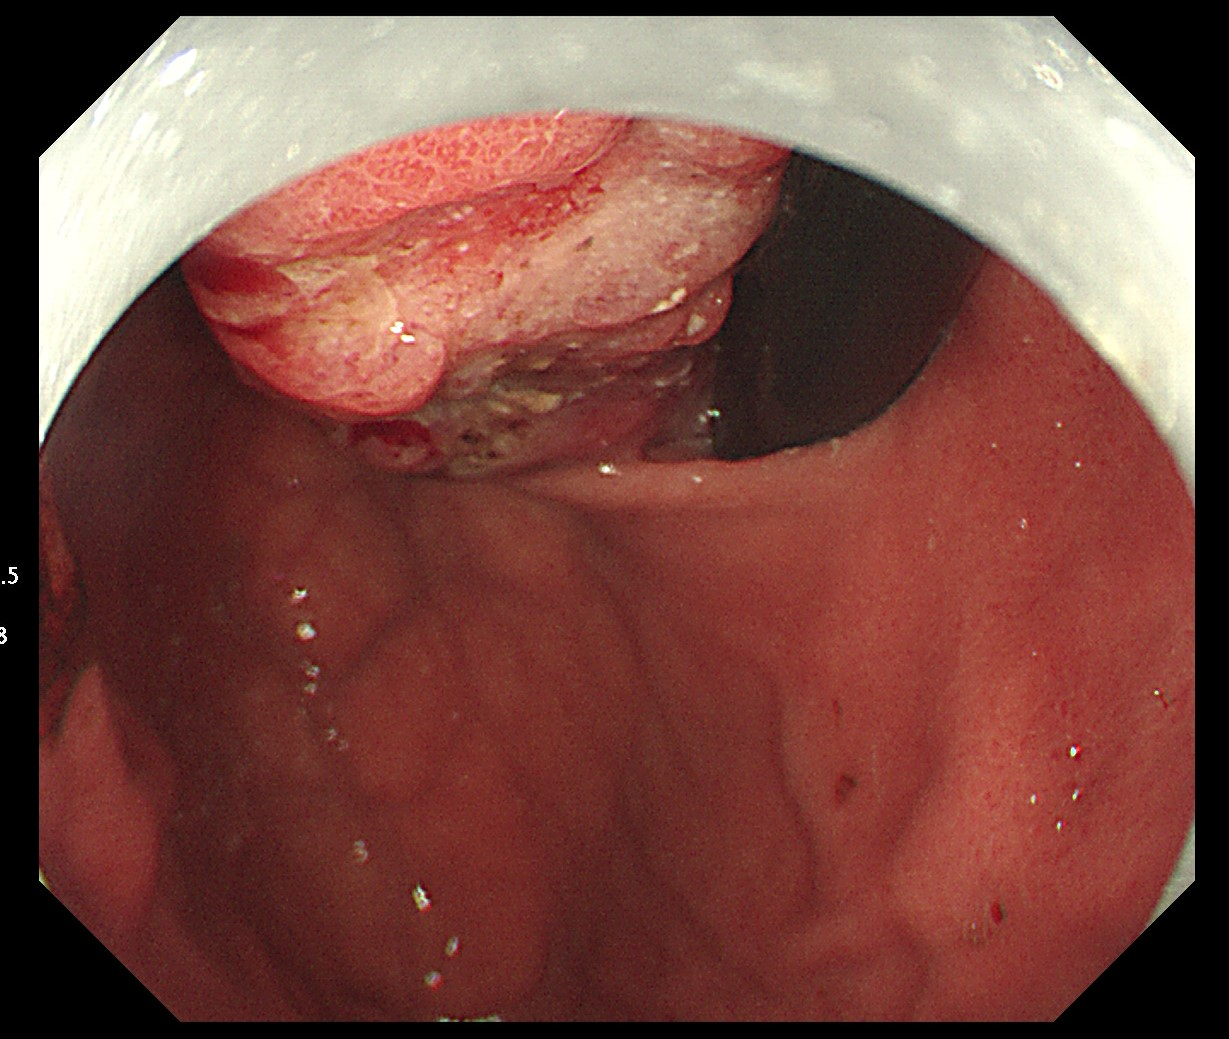

In [ ]:
path = "../Dataset/Training/stomach_cancer_Crop/A01.jpg"

with open(path, "rb") as f:
    image = Image.open(f)
    image.convert("RGB")

    Image._show(image)

In [1]:
a = "123456789"

b = [a for i in range(3)]
b

['123456789', '123456789', '123456789']

In [3]:
from draw_tools.Grad_cam import GradCAM
from Load_process.Load_Indepentend import Load_Indepentend_Data
from Training_Tools.Tools import Tool
from experiments.pytorch_Model import ModifiedXception
from Training_Tools.PreProcess import Training_Precesses
import torch
import json
import torch.nn as nn

model_path = "../Result/save_the_best_model/Xception Skin trains Stomach Cancer Dataset, and uses WeightRandomSampler apply sharpen/Xception/best_model( 2025-05-13 )-_fold0.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('utils/Stomach_Config.json') as f:
    config = json.load(f)
Training_Configs = config['Training_Config']
Loading_Config = config['Loading_Config']

tool = Tool()

tool.Set_OneHotEncording(Loading_Config["Training_Labels"])
Encording_Label = tool.Get_OneHot_Encording_Label()

cut_image = Load_Indepentend_Data(Loading_Config["Training_Labels"], Encording_Label)

Model = ModifiedXception(3)

if torch.cuda.device_count() > 1:
    Model = nn.DataParallel(Model)

Model = Model.to(device)
TargetLayer = Model.base_model.conv4.pointwise

Model.load_state_dict(torch.load(model_path))

# 预处理对象
preprocess = Training_Precesses(256)

cut_image.process_main(Loading_Config["Test_Data_Root"]) # 呼叫處理test Data與Validation Data的function
test, test_label = cut_image.test, cut_image.test_label

# 只评估目标类别
# 转换为PyTorch张量并移动到设备
test_dataset = preprocess.Setting_DataSet(cut_image.test, cut_image.test_label, "Transform")
test_loader = preprocess.Dataloader_Sampler(test_dataset, 1, False)

Grad = GradCAM(Model, TargetLayer)
Grad.Processing_Main(test_loader, f"123456")

stomach_cancer_Crop 有 68 筆資料 
Normal_Crop 有 36 筆資料 
Have_Question_Crop 有 26 筆資料 

test_labels有130筆資料



In [3]:
def f1():
    return 1

import json
with open('utils/Stomach_Config.json') as f:
        config = json.load(f)

a = config["a"]

print(a["Function"])

f1


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride,
                                 padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1,
                                 padding=0, bias=bias)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class EntryFlow(nn.Module):
    def __init__(self):
        super(EntryFlow, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3_residual = nn.Sequential(
            SeparableConv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            SeparableConv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv3_shortcut = nn.Conv2d(64, 128, 1, stride=2, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            SeparableConv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv4_shortcut = nn.Conv2d(128, 256, 1, stride=2, bias=False)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(256, 728, 3, padding=1),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, padding=1),
            nn.BatchNorm2d(728),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv5_shortcut = nn.Conv2d(256, 728, 1, stride=2, bias=False)
        self.bn5 = nn.BatchNorm2d(728)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        
        residual = self.conv3_residual(x)
        shortcut = self.conv3_shortcut(x)
        x = F.relu(self.bn3(residual + shortcut))
        
        residual = self.conv4_residual(x)
        shortcut = self.conv4_shortcut(x)
        x = F.relu(self.bn4(residual + shortcut))
        
        residual = self.conv5_residual(x)
        shortcut = self.conv5_shortcut(x)
        x = F.relu(self.bn5(residual + shortcut))
        return x

class MiddleFlow(nn.Module):
    def __init__(self):
        super(MiddleFlow, self).__init__()
        self.conv_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, padding=1),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, padding=1),
            nn.BatchNorm2d(728),
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 728, 3, padding=1),
            nn.BatchNorm2d(728)
        )
    
    def forward(self, x):
        return self.conv_residual(x) + x

class ExitFlow(nn.Module):
    def __init__(self, num_classes=1000):
        super(ExitFlow, self).__init__()
        self.conv1_residual = nn.Sequential(
            nn.ReLU(inplace=True),
            SeparableConv2d(728, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            SeparableConv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.conv1_shortcut = nn.Conv2d(728, 1024, 1, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)
        
        self.conv2 = nn.Sequential(
            SeparableConv2d(1024, 1536, 3, padding=1),
            nn.BatchNorm2d(1536),
            nn.ReLU(inplace=True),
            SeparableConv2d(1536, 2048, 3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x):
        residual = self.conv1_residual(x)
        shortcut = self.conv1_shortcut(x)
        x = F.relu(self.bn1(residual + shortcut))
        
        x = self.conv2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Xception(nn.Module):
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()
        self.entry_flow = EntryFlow()
        self.middle_flow = nn.Sequential(*[MiddleFlow() for _ in range(8)])
        self.exit_flow = ExitFlow(num_classes)
    
    def forward(self, x):
        x = self.entry_flow(x)
        x = self.middle_flow(x)
        x = self.exit_flow(x)
        return x

def xception(num_classes=1000):
    return Xception(num_classes)

# Example usage:
model = xception(num_classes=1000)
input_tensor = torch.randn(1, 3, 299, 299)
output = model(input_tensor)
print(output.shape)  # Should be torch.Size([1, 1000])

torch.Size([1, 1000])


In [10]:
import cv2
import os
import glob

from utils.Stomach_Config import Loading_Config
from Load_process.file_processing import Process_File
from Load_process.LoadData import Load_Data_Tools

file = Process_File()
Load_Data_Tools = Load_Data_Tools()
Data_Dict_Data = {"TestingProcess_Images" : []}

path = os.path.join("../TestProcess_Image", "*")
path = glob.glob(path)
Training_Data = path

i = 0
file.JudgeRoot_MakeDir(Loading_Config["Process_Roots"])
for Data in Training_Data:
    image = cv2.imread(Data)
    # 轉換為 HSV 色彩空間
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 方法1：固定閾值二值化
    threshold_value = 100  # 閾值，可以調整
    _, binary = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)

    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))  # 橢圓核
    # closing_ellipse = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_ellipse)
    # closing_ellipse = cv2.erode(closing_ellipse, kernel_ellipse, iterations=1)

    path = file.Make_Save_Root(f"{i}.png", Loading_Config["Process_Roots"])
    cv2.imwrite(path, closing_ellipse)
    print(f"完成了{i}張")
    i += 1

完成了0張
完成了1張
完成了2張
完成了3張
完成了4張
完成了5張
完成了6張
完成了7張
完成了8張
完成了9張
完成了10張
完成了11張
完成了12張
完成了13張
完成了14張
完成了15張
完成了16張
完成了17張
完成了18張
完成了19張
完成了20張
完成了21張
完成了22張
完成了23張
完成了24張
完成了25張
完成了26張
完成了27張
完成了28張
完成了29張
完成了30張
完成了31張
完成了32張
完成了33張
完成了34張
完成了35張
完成了36張
完成了37張
完成了38張
完成了39張
完成了40張
完成了41張
完成了42張
完成了43張
完成了44張
完成了45張
完成了46張
完成了47張
完成了48張
完成了49張
完成了50張
完成了51張
完成了52張
完成了53張
完成了54張
完成了55張
完成了56張
完成了57張
完成了58張
完成了59張
完成了60張
完成了61張
完成了62張
完成了63張
完成了64張
完成了65張
完成了66張
完成了67張
完成了68張
完成了69張
完成了70張
完成了71張
完成了72張
完成了73張
完成了74張
完成了75張
完成了76張
完成了77張
完成了78張
完成了79張
完成了80張
完成了81張
完成了82張
完成了83張
完成了84張
完成了85張
完成了86張
完成了87張
完成了88張
完成了89張
完成了90張
完成了91張
完成了92張
完成了93張
完成了94張
完成了95張
完成了96張
完成了97張
完成了98張
完成了99張
完成了100張
完成了101張
完成了102張
完成了103張
完成了104張
完成了105張
完成了106張
完成了107張
完成了108張
完成了109張
完成了110張
完成了111張
完成了112張
完成了113張
完成了114張
完成了115張
完成了116張
完成了117張
完成了118張
完成了119張
完成了120張
完成了121張
完成了122張
完成了123張
完成了124張
完成了125張
完成了126張
完成了127張
完成了128張
完成了129張
完成了130張
完成了131張
完成了132張
完成了133張
完成了134張
完成了135張
完成了136張
完成了137張
完成了138

In [1]:
import xml.etree.ElementTree as ET
import cv2
import os
import numpy as np
from typing import List, Dict, Optional, Tuple
from utils.Stomach_Config import Loading_Config

class XMLAnnotationProcessor:
    """
    XML標註檔案處理器
    專門處理包含bounding box資訊的XML檔案，並在對應圖片上繪製邊界框
    """
    
    def __init__(self, dataset_root: str = "../Dataset/Training"):
        """
        初始化XML處理器
        
        Args:
            dataset_root: 圖片資料集根目錄
            output_folder: 輸出資料夾
        """
        self.dataset_root = dataset_root
        self.box_color = (0, 255, 0)  # 綠色邊界框
        self.text_color = (0, 255, 0)  # 綠色文字
        self.box_thickness = 2
        self.font_scale = 0.5
        self.font = cv2.FONT_HERSHEY_SIMPLEX
    
    def _ensure_output_folder(self, Save_Root: str) -> None:
        """確保輸出資料夾存在"""
        if not os.path.exists(Save_Root):
            os.makedirs(Save_Root)
    
    def parse_xml(self, xml_file_path: str, Label: str) -> Optional[Dict]:
        """
        解析XML檔案並提取所有相關資訊
        
        Args:
            xml_file_path: XML檔案路徑
            
        Returns:
            Dict: 包含檔案資訊和bounding box的字典，解析失敗時返回None
        """
        try:
            tree = ET.parse(xml_file_path)
            root = tree.getroot()
            
            # 提取基本資訊
            filename_element = root.find('filename')
            
            if filename_element is None:
                print(f"找不到path元素在 {xml_file_path}")
                return None
            
            filename = filename_element.text if filename_element is not None else "Unknown"
            Original_Image_Data_Root = os.path.join(self.dataset_root, Label)
            Original_Image_Data_Root = os.path.join(Original_Image_Data_Root, filename)
            
            # 提取圖片尺寸
            size_element = root.find('size')
            width = int(size_element.find('width').text) if size_element is not None else 0
            height = int(size_element.find('height').text) if size_element is not None else 0
            depth = int(size_element.find('depth').text) if size_element is not None else 3
            
            # 提取所有bounding box
            bounding_boxes = []
            objects = root.findall('object')
            
            for obj in objects:
                bndbox = obj.find('bndbox')
                if bndbox is not None:
                    bbox_info = {
                        'name': obj.find('name').text if obj.find('name') is not None else "Unknown",
                        'pose': obj.find('pose').text if obj.find('pose') is not None else "Unspecified",
                        'truncated': int(obj.find('truncated').text) if obj.find('truncated') is not None else 0,
                        'difficult': int(obj.find('difficult').text) if obj.find('difficult') is not None else 0,
                        'xmin': int(bndbox.find('xmin').text),
                        'ymin': int(bndbox.find('ymin').text),
                        'xmax': int(bndbox.find('xmax').text),
                        'ymax': int(bndbox.find('ymax').text)
                    }
                    bounding_boxes.append(bbox_info)
            
            return {
                'filename': filename,
                'image_path': Original_Image_Data_Root,
                'width': width,
                'height': height,
                'depth': depth,
                'bounding_boxes': bounding_boxes
            }
            
        except Exception as e:
            print(f"解析XML檔案 {xml_file_path} 時發生錯誤: {str(e)}")
            return None
    
    def load_image(self, image_path: str) -> Optional[np.ndarray]:
        """
        載入圖片檔案
        
        Args:
            image_path: 圖片檔案路徑
            
        Returns:
            np.ndarray: 圖片陣列，載入失敗時返回None
        """
        if not os.path.exists(image_path):
            print(f"圖片檔案不存在: {image_path}")
            return None
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"無法讀取圖片: {image_path}")
            return None
        
        return image
    
    def draw_bounding_boxes(self, image: np.ndarray, bounding_boxes: List[Dict]) -> np.ndarray:
        """
        創建遮罩圖片：bounding box內為白色，外部為黑色
        
        Args:
            image: 圖片陣列
            bounding_boxes: bounding box資訊列表
            
        Returns:
            np.ndarray: 處理後的遮罩圖片陣列
        """
        # 創建黑色背景圖片
        height, width = image.shape[:2]
        result_image = np.zeros((height, width, 3), dtype=np.uint8)
        
        for i, bbox in enumerate(bounding_boxes):
            xmin, ymin = bbox['xmin'], bbox['ymin']
            xmax, ymax = bbox['xmax'], bbox['ymax']
            object_name = bbox['name']
            
            # 確保座標在圖片範圍內
            xmin = max(0, min(xmin, width-1))
            ymin = max(0, min(ymin, height-1))
            xmax = max(0, min(xmax, width-1))
            ymax = max(0, min(ymax, height-1))
            
            # 將bounding box範圍內設為白色 (255, 255, 255)
            result_image[ymin:ymax, xmin:xmax] = [255, 255, 255]
            
            print(f"Object {i+1}: {object_name} - 座標: ({xmin}, {ymin}, {xmax}, {ymax})")
        
        return result_image
    
    def save_annotated_image(self, image: np.ndarray, original_filename: str, Label : str) -> str:
        """
        儲存標註後的圖片
        
        Args:
            image: 標註後的圖片陣列
            original_filename: 原始檔案名稱
            
        Returns:
            str: 儲存的檔案路徑
        """
        output_filename = f"annotated_{original_filename}"
        output_path = os.path.join(Loading_Config["Annotation_Root"], Label)
        Save_Image_Roots = os.path.join(output_path, output_filename)
        # 確保輸出資料夾存在
        self._ensure_output_folder(output_path)

        cv2.imwrite(Save_Image_Roots, image)
        print(f"已儲存標註圖片至: {Save_Image_Roots}")
        return Save_Image_Roots
    
    def process_single_xml(self, xml_file_path: str, Label : str) -> Optional[Tuple[np.ndarray, str]]:
        """
        處理單一XML檔案
        
        Args:
            xml_file_path: XML檔案路徑
            
        Returns:
            Tuple[np.ndarray, str]: (標註後的圖片, 輸出路徑)，處理失敗時返回None
        """
        # 解析XML
        xml_data = self.parse_xml(xml_file_path, Label)
        if xml_data is None:
            return None
        
        # 載入圖片
        image = self.load_image(xml_data['image_path'])
        if image is None:
            return None
        
        # 繪製bounding box
        annotated_image = self.draw_bounding_boxes(image, xml_data['bounding_boxes'])
        
        # 儲存結果
        output_path = self.save_annotated_image(annotated_image, xml_data['filename'], Label)
        
        return annotated_image, output_path
    
    def process_multiple_xml(self, xml_folder_path: str, Label : str) -> List[Tuple[str, bool]]:
        """
        批量處理多個XML檔案
        
        Args:
            xml_folder_path: 包含XML檔案的資料夾路徑
            
        Returns:
            List[Tuple[str, bool]]: [(檔案名稱, 處理成功與否), ...]
        """
        if not os.path.exists(xml_folder_path):
            print(f"XML資料夾不存在: {xml_folder_path}")
            return []
        
        xml_files = [f for f in os.listdir(xml_folder_path) if f.endswith('.xml')]
        
        if not xml_files:
            print(f"在 {xml_folder_path} 中找不到XML檔案")
            return []
        
        print(f"找到 {len(xml_files)} 個XML檔案")
        for xml_file in xml_files:            
            try:
                Read_XML_File = os.path.join(xml_folder_path, xml_file)
                self.process_single_xml(Read_XML_File, Label)
                print(f"\n處理檔案: {xml_file}")
            except Exception as e:
                print(f"處理 {xml_file} 時發生錯誤: {str(e)}")
                return
    
    def get_bounding_boxes_info(self, xml_file_path: str) -> Optional[Dict]:
        """
        僅提取XML中的bounding box資訊，不進行圖片處理
        
        Args:
            xml_file_path: XML檔案路徑
            
        Returns:
            Dict: 包含檔案資訊和bounding box座標的字典
        """
        return self.parse_xml(xml_file_path)
    
    def set_drawing_style(self, box_color: Tuple[int, int, int] = None, 
                         text_color: Tuple[int, int, int] = None,
                         box_thickness: int = None, 
                         font_scale: float = None) -> None:
        """
        設定繪圖樣式
        
        Args:
            box_color: 邊界框顏色 (B, G, R)
            text_color: 文字顏色 (B, G, R)
            box_thickness: 邊界框粗細
            font_scale: 字體大小
        """
        if box_color is not None:
            self.box_color = box_color
        if text_color is not None:
            self.text_color = text_color
        if box_thickness is not None:
            self.box_thickness = box_thickness
        if font_scale is not None:
            self.font_scale = font_scale

In [2]:
# 創建處理器實例
processor = XMLAnnotationProcessor(
    dataset_root = Loading_Config["Train_Data_Root"],
)

# 設定自訂樣式（可選）
processor.set_drawing_style(
    box_color=(0, 0, 255),  # 紅色邊界框
    text_color=(255, 255, 255),  # 白色文字
    box_thickness=3,
    font_scale=0.7
)

print("XML標註處理器已準備就绪")
results = processor.process_multiple_xml(f"../Label_Image/Have_Question", "Have_Question_Crop")

XML標註處理器已準備就绪
找到 232 個XML檔案
Object 1: Have_Question - 座標: (263, 740, 333, 814)
已儲存標註圖片至: ../Dataset/Annotation\Have_Question_Crop\annotated_a00.jpg

處理檔案: a00.xml
Object 1: Have_Question - 座標: (406, 206, 608, 368)
已儲存標註圖片至: ../Dataset/Annotation\Have_Question_Crop\annotated_A1000.jpg

處理檔案: A1000.xml
Object 1: Have_Question - 座標: (740, 330, 819, 401)
已儲存標註圖片至: ../Dataset/Annotation\Have_Question_Crop\annotated_A1002.jpg

處理檔案: A1002.xml
圖片檔案不存在: ../Dataset/Training\Have_Question_Crop\A1010.jpg

處理檔案: A1010.xml
Object 1: Have_Question - 座標: (349, 655, 474, 790)
已儲存標註圖片至: ../Dataset/Annotation\Have_Question_Crop\annotated_A1012.jpg

處理檔案: A1012.xml
Object 1: Have_Question - 座標: (707, 89, 1206, 746)
Object 2: Have_Question - 座標: (100, 199, 410, 816)
已儲存標註圖片至: ../Dataset/Annotation\Have_Question_Crop\annotated_A1020.jpg

處理檔案: A1020.xml
Object 1: Have_Question - 座標: (720, 391, 769, 439)
Object 2: Have_Question - 座標: (833, 621, 969, 733)
Object 3: Have_Question - 座標: (337, 595, 735, 900)
已儲